In [ ]:
 # STEP 1 Mount Google drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 2 - EXTRACTION OF ZIP FILE
from google.colab import drive
import zipfile
import os

# Define paths
zip_path = "/content/drive/MyDrive/MRI Alzheimer /MRI_scan.zip"
extract_path = "/content/MRI Alzheimer "

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")

Extraction completed!


In [ ]:
!ls "/content/MRI Alzheimer "
!ls "/content/MRI Alzheimer /MRI_scan"

MRI_scan
AugmentedAlzheimerDataset  OriginalDataset


In [ ]:
import shutil
import random

# Define dataset directories
train_dir = "/content/MRI Alzheimer /MRI_scan/AugmentedAlzheimerDataset"
test_dir = "/content/MRI Alzheimer /MRI_scan/OriginalDataset"

# Define new balanced dataset directories
balanced_train_dir = "/content/MRI_Alzheimer_Balanced/Training"
balanced_test_dir = "/content/MRI_Alzheimer_Balanced/Testing"

# Ensure the new directories exist
os.makedirs(balanced_train_dir, exist_ok=True)
os.makedirs(balanced_test_dir, exist_ok=True)

# Function to randomly select 1000 images per class
def balance_dataset(source_dir, target_dir, num_samples=1000):
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

            # Randomly select images
            selected_images = random.sample(images, min(num_samples, len(images)))

            # Create class directory in new dataset folder
            target_class_dir = os.path.join(target_dir, class_name)
            os.makedirs(target_class_dir, exist_ok=True)

            # Copy selected images to new folder
            for img in selected_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(target_class_dir, img))

# Apply function to training & testing sets
balance_dataset(train_dir, balanced_train_dir, num_samples=1000)
balance_dataset(test_dir, balanced_test_dir, num_samples=1000)

# New dataset distribution
print("Balanced Training Dataset:", {cls: len(os.listdir(os.path.join(balanced_train_dir, cls))) for cls in os.listdir(balanced_train_dir)})
print("Balanced Testing Dataset:", {cls: len(os.listdir(os.path.join(balanced_test_dir, cls))) for cls in os.listdir(balanced_test_dir)})


Balanced Training Dataset: {'ModerateDemented': 1000, 'VeryMildDemented': 1000, 'NonDemented': 1000, 'MildDemented': 1000}
Balanced Testing Dataset: {'ModerateDemented': 64, 'VeryMildDemented': 1000, 'NonDemented': 1000, 'MildDemented': 896}


In [ ]:
import os

train_dir = '/content/MRI Alzheimer /MRI_scan/AugmentedAlzheimerDataset'
test_dir = '/content/MRI Alzheimer /MRI_scan/OriginalDataset'

print("Train Directory Exists:", os.path.exists(train_dir))
print("Test Directory Exists:", os.path.exists(test_dir))


Train Directory Exists: True
Test Directory Exists: True


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    balanced_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Training set (80%)
    shuffle=True
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    balanced_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Validation set (20%)
    shuffle=True
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    balanced_test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 2960 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 396s 4s/step - accuracy: 0.3236 - loss: 1.5519 - val_accuracy: 0.5000 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step - accuracy: 0.5246 - loss: 1.0802 - val_accuracy: 0.6037 - val_loss: 0.8960 - learning_rate: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 405s 4s/step - accuracy: 0.6246 - loss: 0.8588 - val_accuracy: 0.6288 - val_loss: 0.8193 - learning_rate: 0.0010
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.6878 - loss: 0.7595 - val_accuracy: 0.6700 - val_loss: 0.7495 - learning_rate: 0.0010
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step - accuracy: 0.7256 - loss: 0.6306 - val_accuracy: 0.6775 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 409s 4s/step - accuracy: 0.7547 - loss: 0.5574 - val_accuracy: 0.6938 - val_loss: 0.7332 - learning_rate: 0.0010
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - accuracy: 0.8073 - loss: 0.

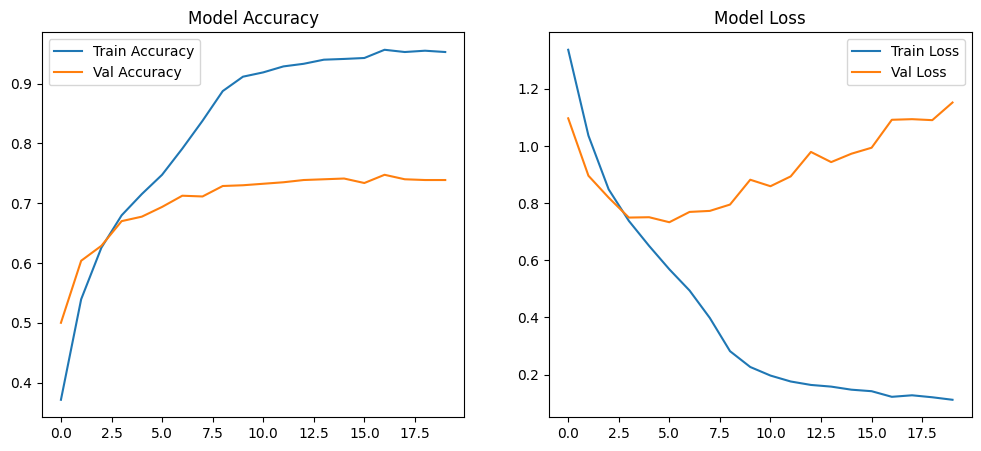

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions
predictions = model.predict(test_generator)
pred_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=test_generator.class_indices.keys()))


93/93 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step
Confusion Matrix:
[[849   0  15  32]
 [  0  64   0   0]
 [114   4 724 158]
 [159   4 140 697]]
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.76      0.95      0.84       896
ModerateDemented       0.89      1.00      0.94        64
     NonDemented       0.82      0.72      0.77      1000
VeryMildDemented       0.79      0.70      0.74      1000

        accuracy                           0.79      2960
       macro avg       0.81      0.84      0.82      2960
    weighted avg       0.79      0.79      0.78      2960



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/MyDrive/MRI Alzheimer /alzheimer_model.keras")
print("✅ Model saved in Google Drive!")

import joblib

joblib.dump(model,"/content/drive/MyDrive/MRI Alzheimer /alzheimer_model.sav")  # Save the model
print("✅ Model saved in Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved in Google Drive!
✅ Model saved in Google Drive!


In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

# Define class labels
CLASS_LABELS = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Define MRI-based explanations for each class
CLASS_DESCRIPTIONS = {
    "MildDemented": (
        "MRI analysis indicates mild atrophy in the hippocampus and medial temporal lobes, "
        "which are early markers of neurodegeneration. Mild ventricular enlargement may also be present, "
        "suggesting slight brain volume loss associated with early-stage dementia."
    ),
    "ModerateDemented": (
        "The scan reveals significant shrinkage in the hippocampus and cerebral cortex, "
        "with noticeable ventricular enlargement. White matter hyperintensities may be more pronounced, "
        "indicating moderate progression of neurodegeneration."
    ),
    "NonDemented": (
        "No significant cortical atrophy or ventricular enlargement is observed. "
        "The hippocampal region appears intact, with normal white and gray matter distribution. "
        "Brain volume and structure are consistent with a healthy, non-demented individual."
    ),
    "VeryMildDemented": (
        "Subtle reduction in hippocampal volume and mild cortical thinning are detected, "
        "which may indicate early-stage neurodegeneration. However, these changes are minimal and do not yet "
        "significantly impact cognitive function."
    )
}

# Load trained CNN model
model_path = "D:/Documents/Alzheimer/models/AlzheimerCnn_model_fixed.keras"  # Update this path if needed

try:
    model = tf.keras.models.load_model(model_path, compile=False)
except OSError:
    st.error("❌ Error: Unable to load model. Please check the file path or format.")
    model = None  # Set model to None if loading fails

def preprocess_image(img):
    """Preprocess the image for CNN prediction."""
    try:
        img = img.convert("RGB")  # Ensure correct format
        img_array = image.img_to_array(img)
        img_array = tf.image.resize(img_array, (224, 224))  # Resize efficiently
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values
        return img_array
    except Exception as e:
        st.error(f"❌ Error processing image: {e}")
        return None

def predict_image(img):
    """Predict the class of an MRI scan using the CNN model."""
    if model is None:
        return "Model not loaded", None

    img_array = preprocess_image(img)
    if img_array is None:
        return "Error processing image", None

    prediction = model.predict(img_array)
    predicted_class = CLASS_LABELS[np.argmax(prediction)]
    description = CLASS_DESCRIPTIONS.get(predicted_class, "No description available.")

    return predicted_class, description

# Streamlit App
st.title("🧠 AlzDetect - Alzheimer MRI Analysis")

# Sidebar Navigation
st.sidebar.title("Navigation")
page = st.sidebar.radio("Go to", ["MRI Scan Analysis"])

# ---- MRI SCAN ANALYSIS PAGE ----
if page == "MRI Scan Analysis":
    st.header("Upload & Analyze MRI Scan")

    mri_file = st.file_uploader("Upload an MRI scan (JPG/PNG)", type=["jpg", "png"])

    if mri_file is not None:
        try:
            img = Image.open(mri_file)
            st.image(img, caption="Uploaded MRI Scan", use_container_width=True)

            if st.button("🔍 Analyze MRI Scan"):
                predicted_class, description = predict_image(img)

                if predicted_class == "Model not loaded":
                    st.error("❌ The model is not available. Please check the file path.")
                elif predicted_class == "Error processing image":
                    st.error("❌ Error processing the image. Please upload a valid file.")
                else:
                    st.success(f"**Predicted Diagnosis:** {predicted_class}")
                    st.write("📊 **MRI Scan Analysis:**")
                    st.info(description)

        except Exception as e:
            st.error(f"❌ Error loading image: {e}")

# Sidebar Info
st.sidebar.info("🚀 Deep Learning Model - MRI Analysis with CNN!")
